In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')
df.shape

(137, 43)

In [3]:
test_df = pd.read_csv('test.csv')
test_df.shape

(100000, 42)

In [4]:
df.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [5]:
df.isnull().sum()

Id            0
Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
revenue       0
dtype: int64

### EDA

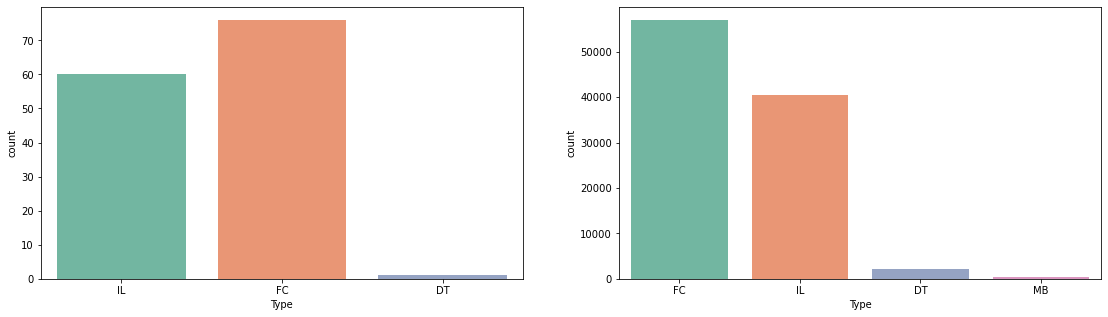

In [6]:
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(df['Type'],palette="Set2", ax=ax[0]);
g2 = sns.countplot(test_df['Type'],palette="Set2", ax=ax[1]);
fig.show()

In [7]:
test_df.loc[test_df['Type']=='MB', 'Type'] = 'DT' # mobile more related to drive thru than others

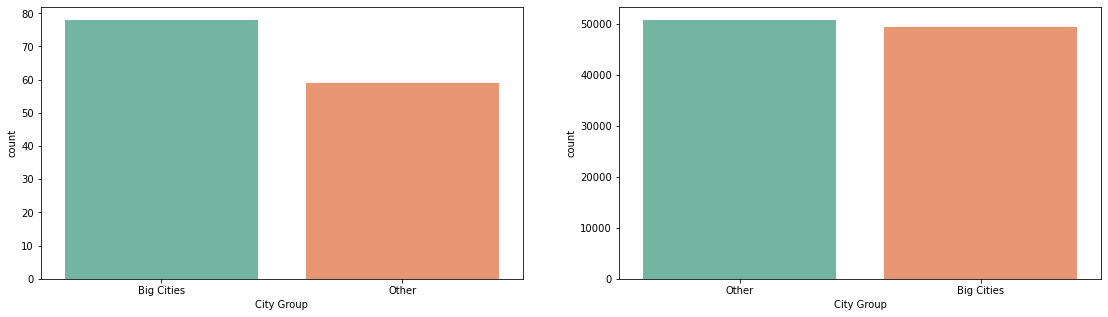

In [8]:
fig, ax = plt.subplots(1,2, figsize=(19, 5))
g1 = sns.countplot(df['City Group'],palette="Set2", ax=ax[0]);
g2 = sns.countplot(test_df['City Group'],palette="Set2", ax=ax[1]);
fig.show()

In [9]:
(df['City'].nunique(), test_df['City'].nunique())

(34, 57)

In [10]:
df.drop('City', axis=1, inplace=True)
test_df.drop('City', axis=1, inplace=True)

**Opening Date**

In [11]:
import datetime
df.drop('Id',axis=1,inplace=True)
df['Open Date']  = pd.to_datetime(df['Open Date'])
test_df['Open Date']  = pd.to_datetime(test_df['Open Date'])
launch_date = datetime.datetime(2015, 3, 23)
# scale days open
df['Days Open'] = (launch_date - df['Open Date']).dt.days / 1000
test_df['Days Open'] = (launch_date - test_df['Open Date']).dt.days / 1000
df.drop('Open Date', axis=1, inplace=True)
test_df.drop('Open Date', axis=1, inplace=True)

**P variables**

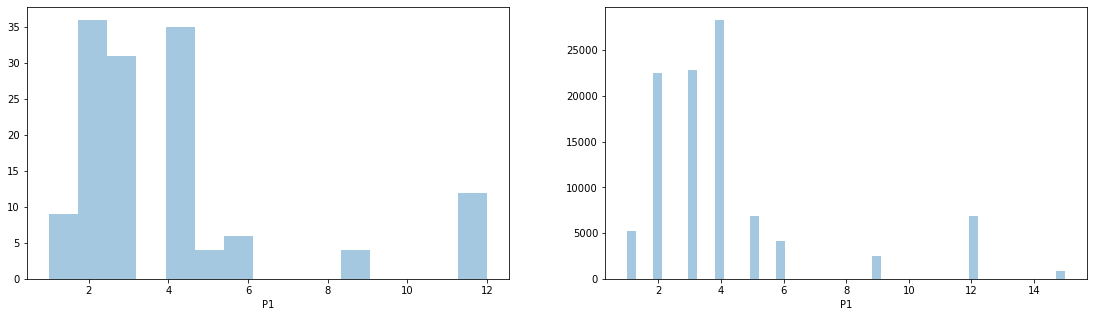

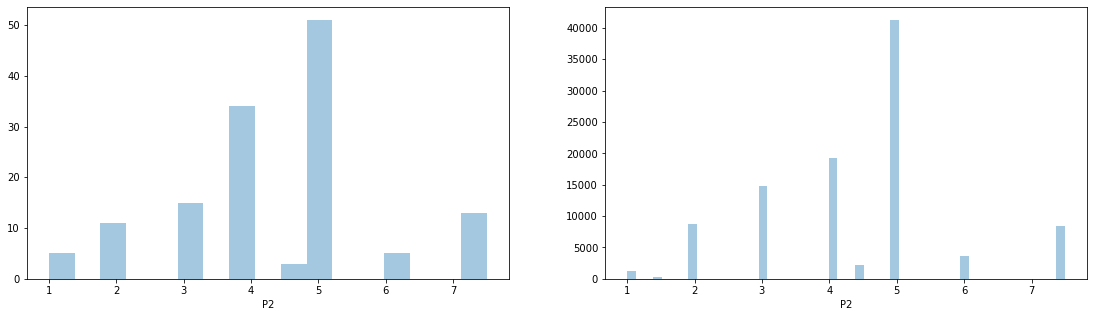

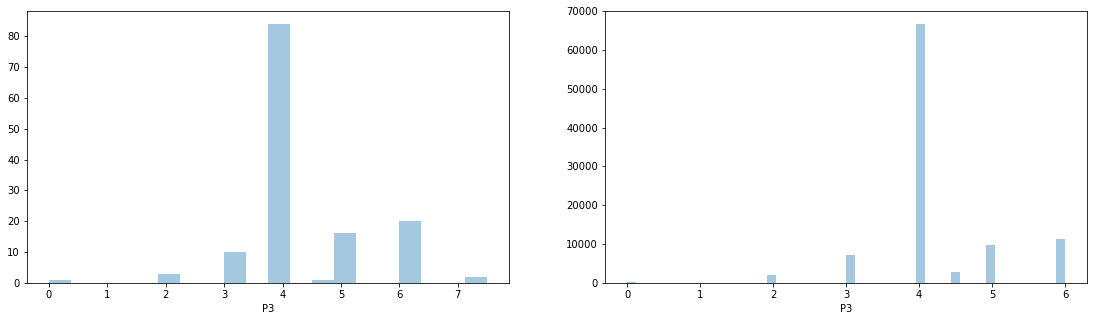

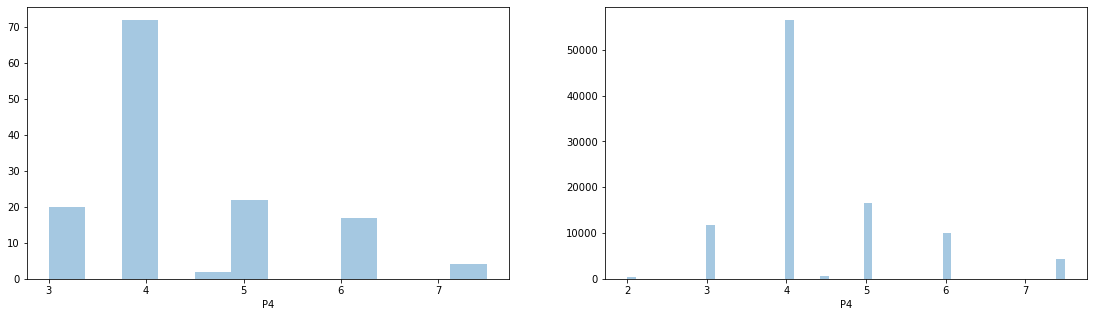

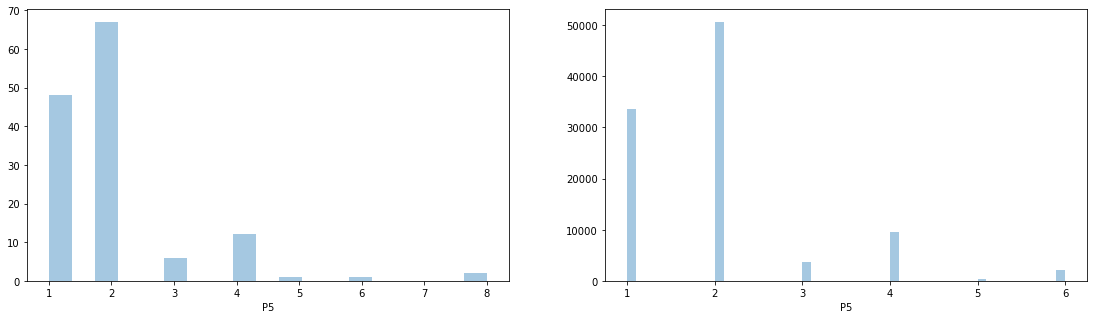

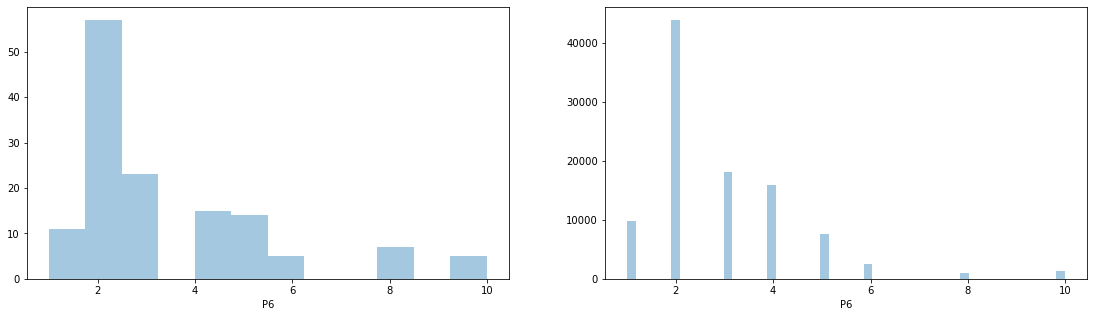

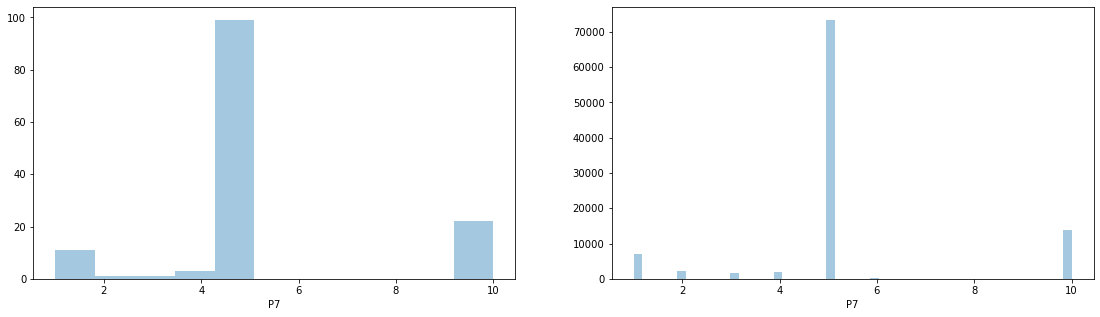

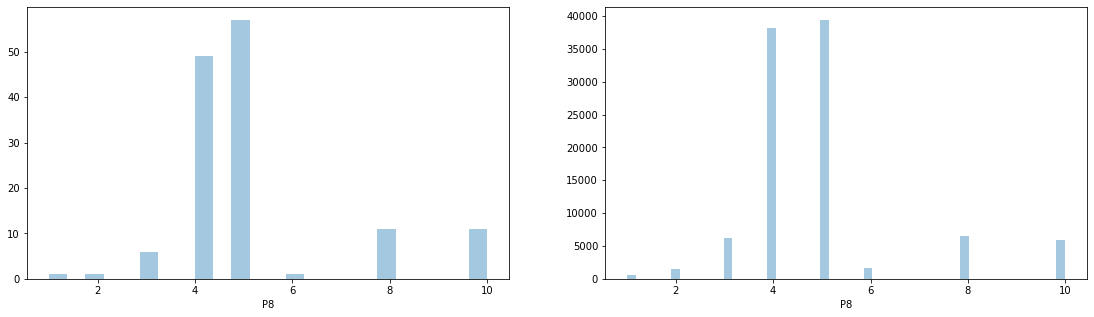

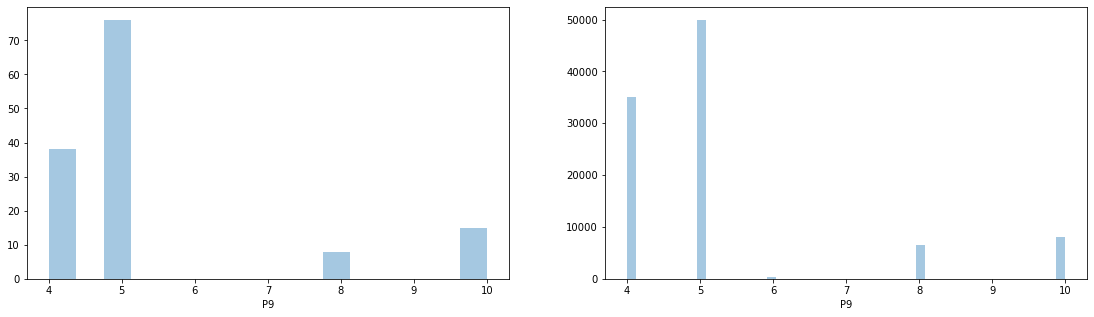

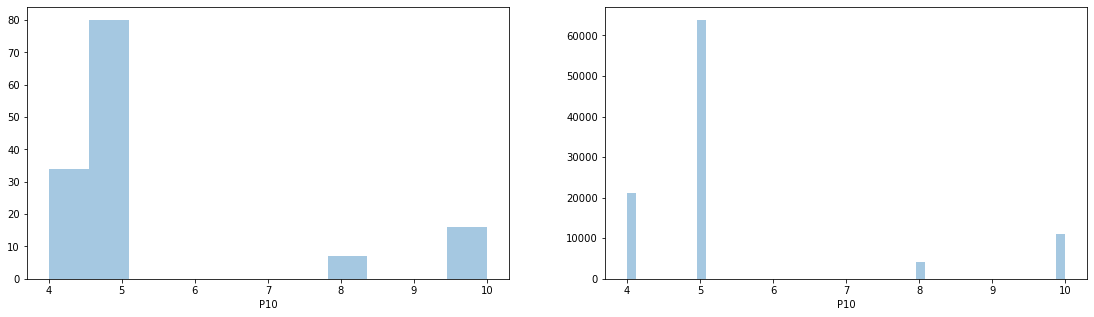

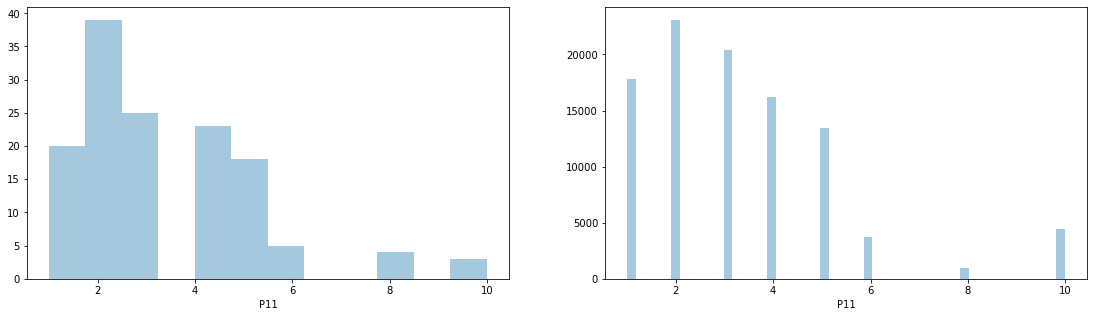

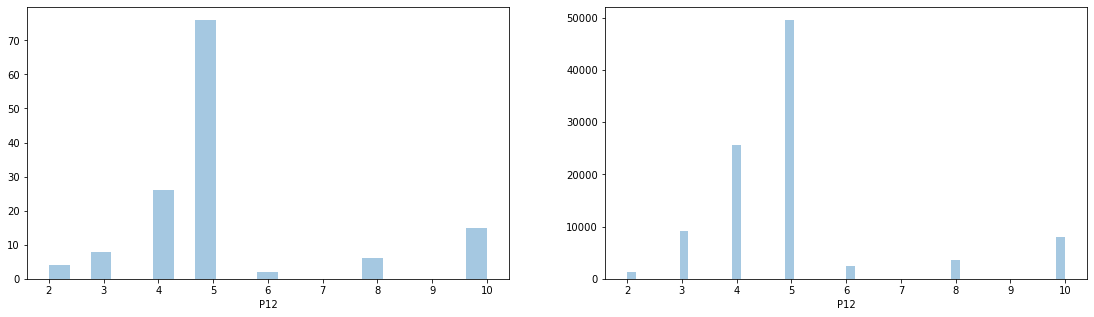

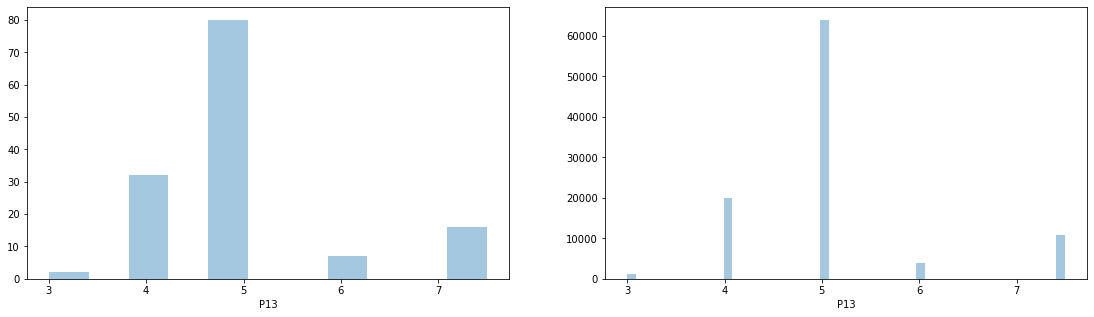

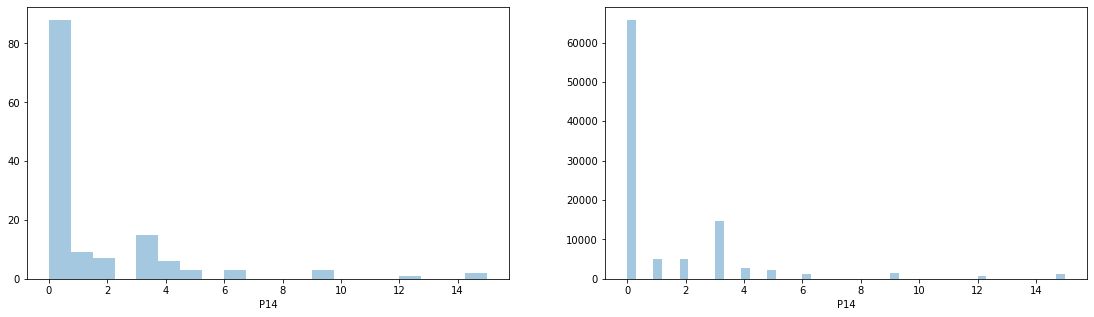

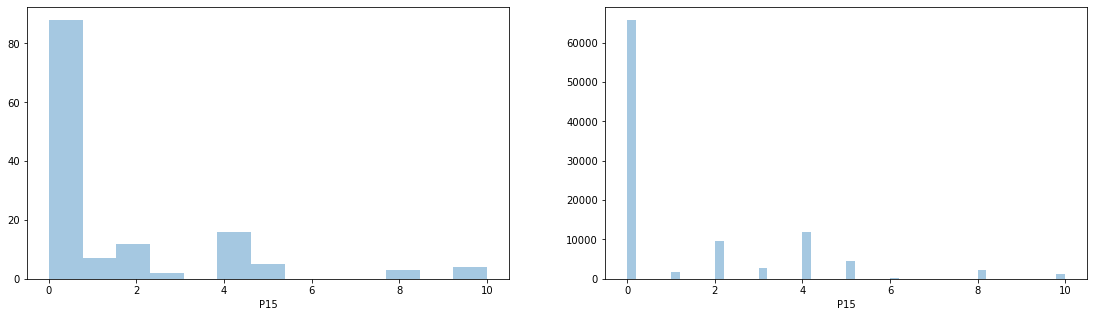

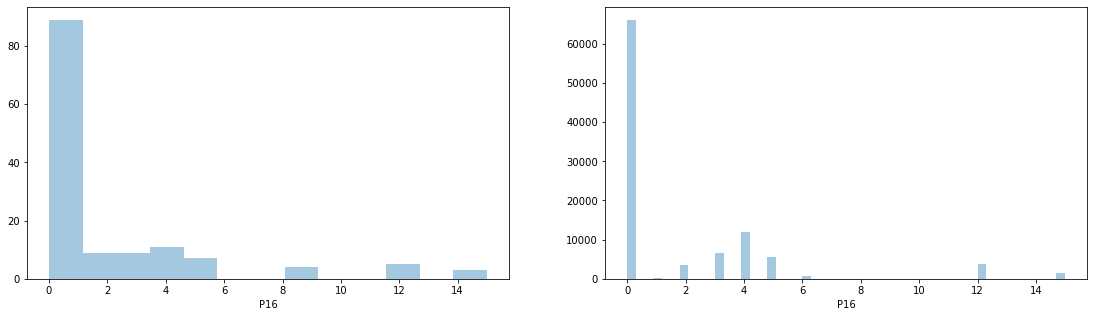

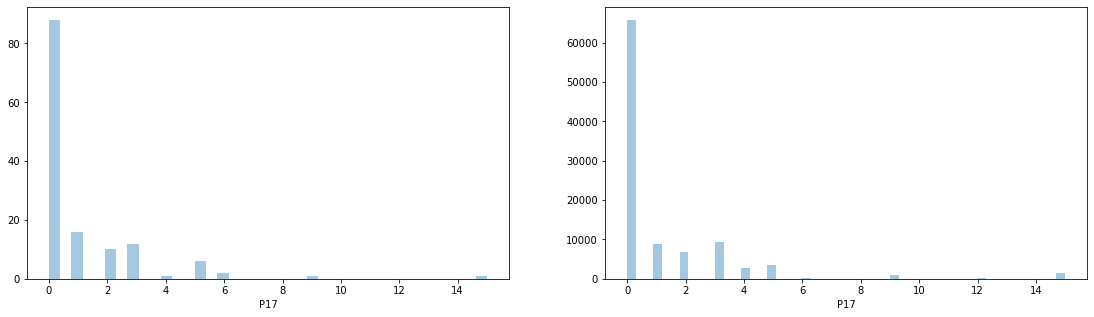

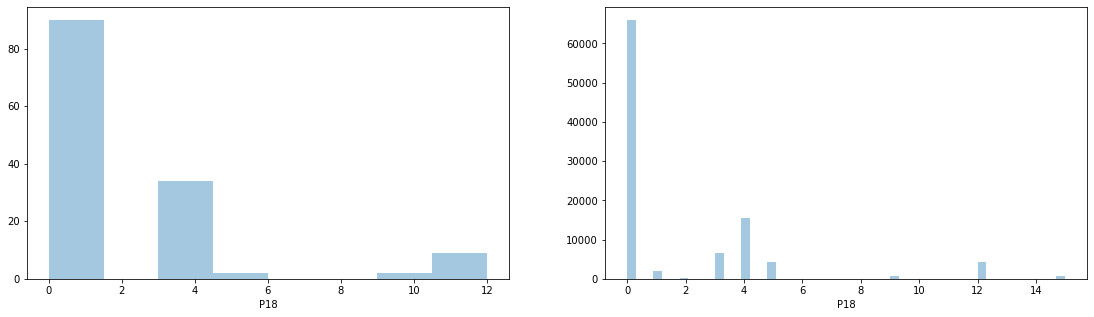

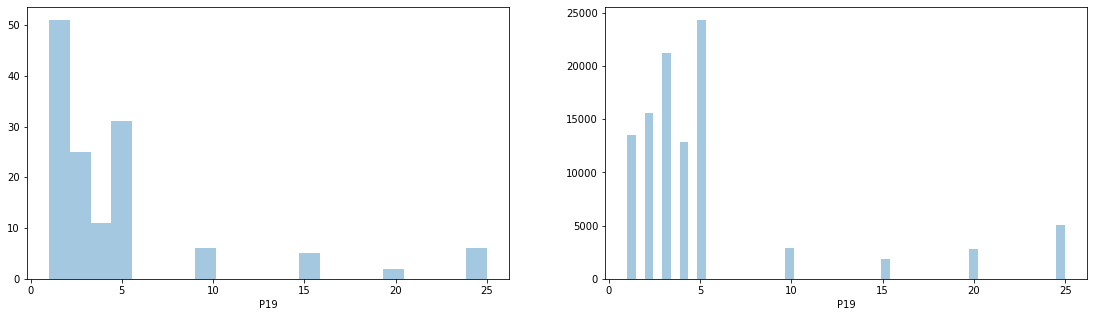

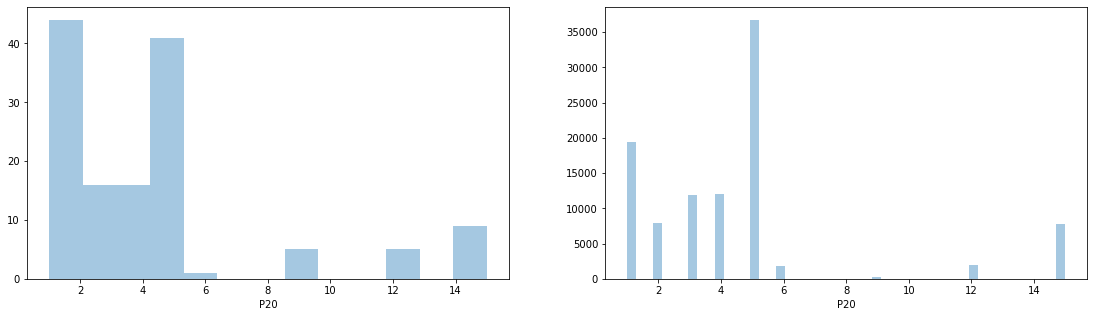

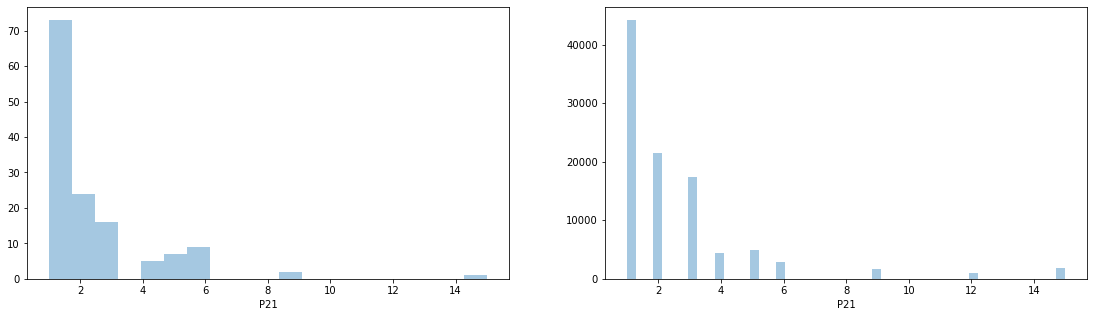

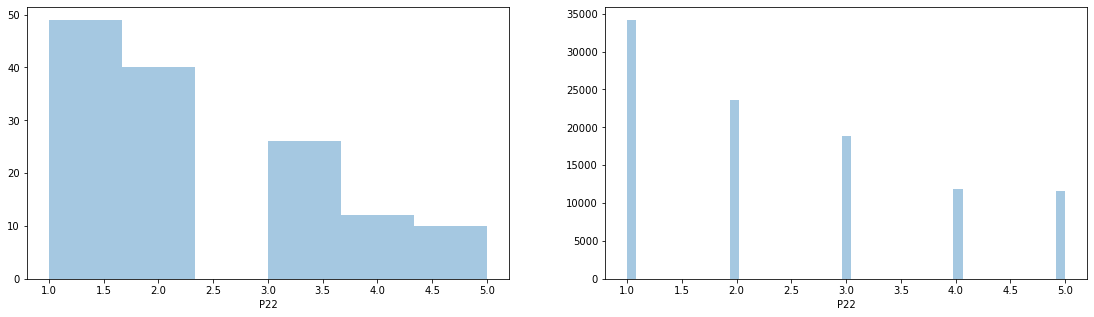

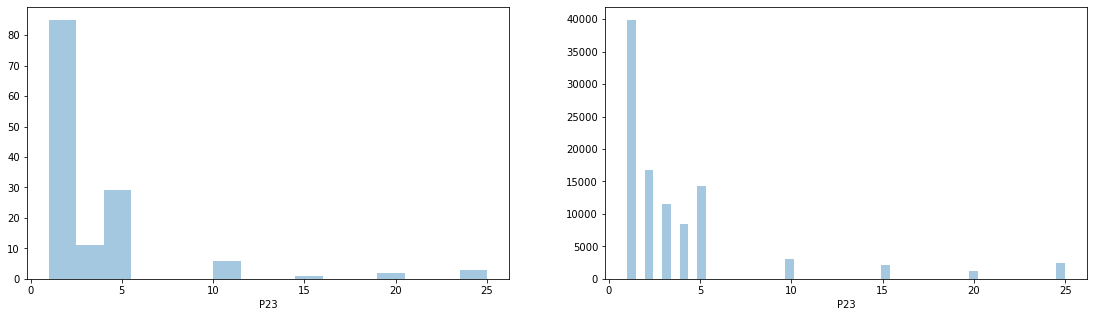

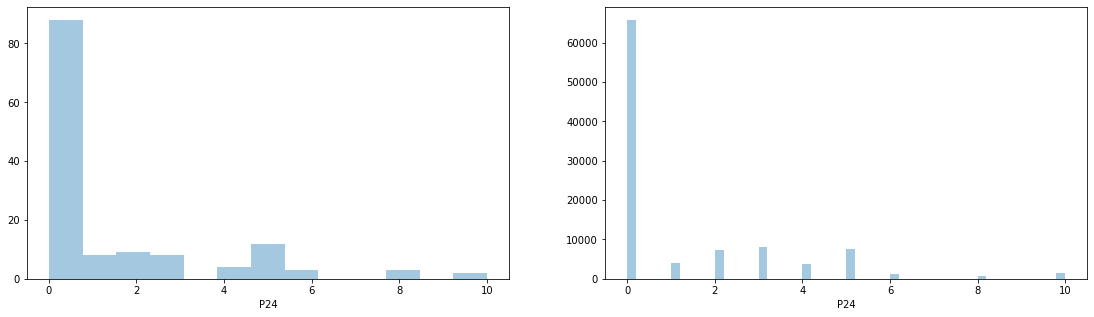

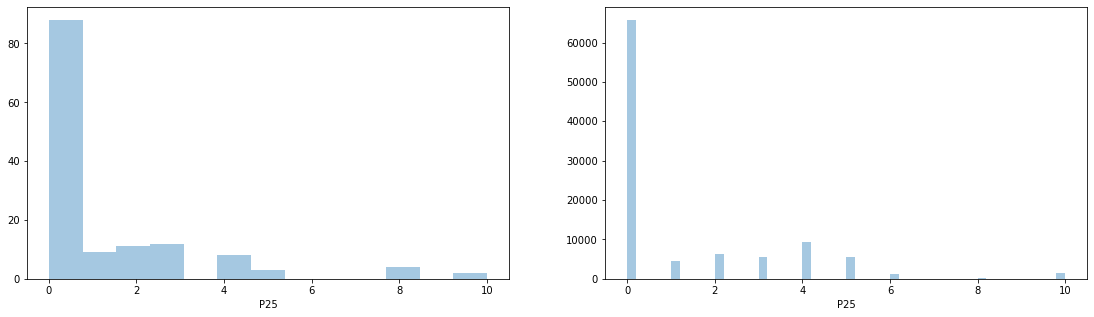

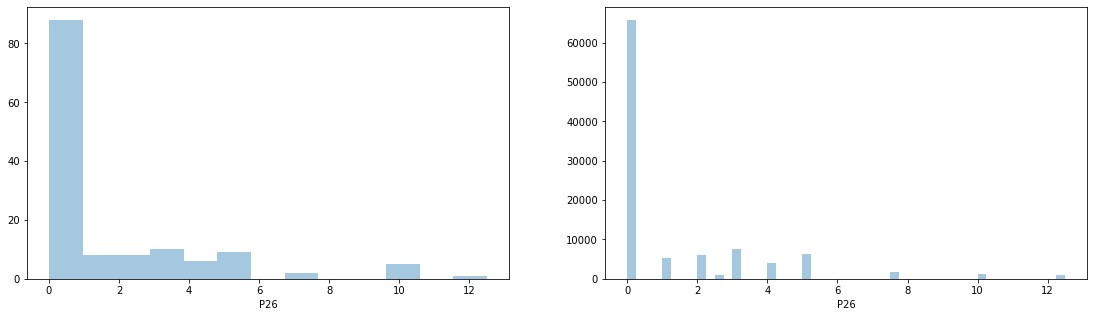

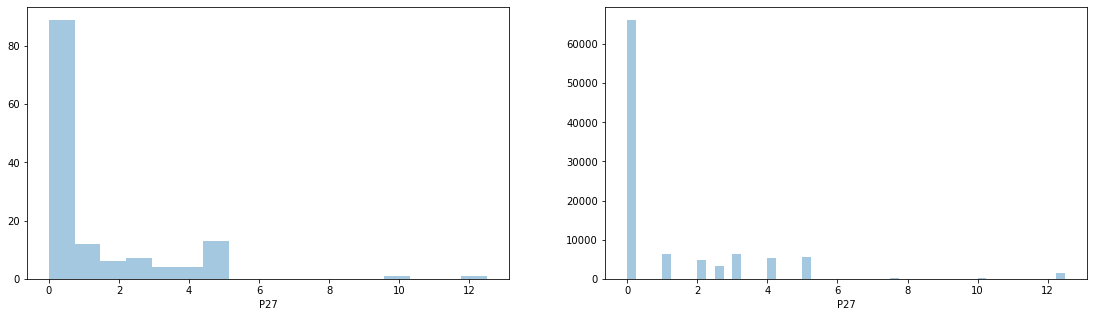

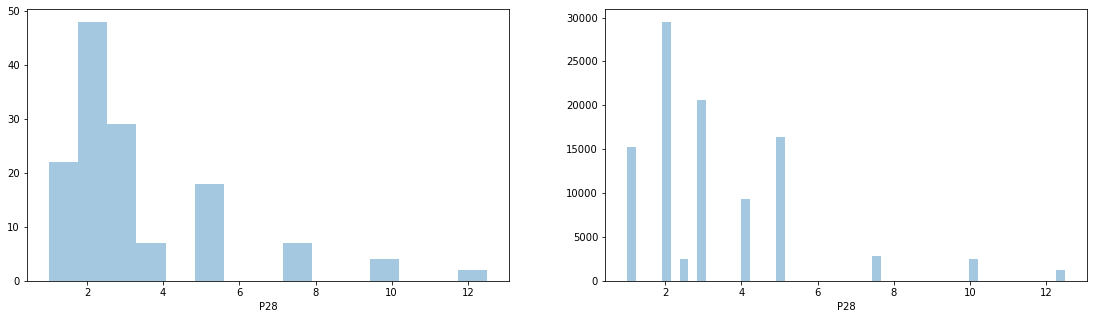

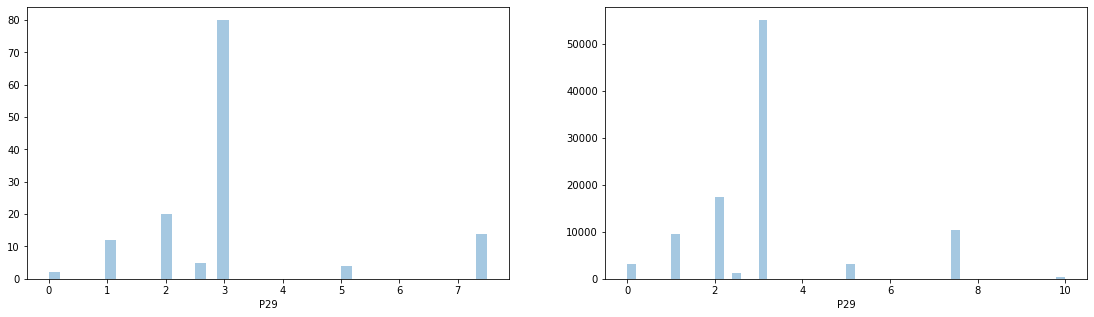

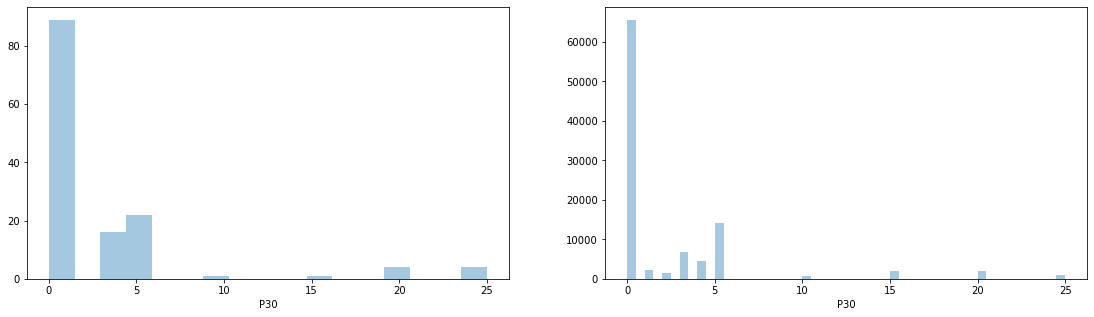

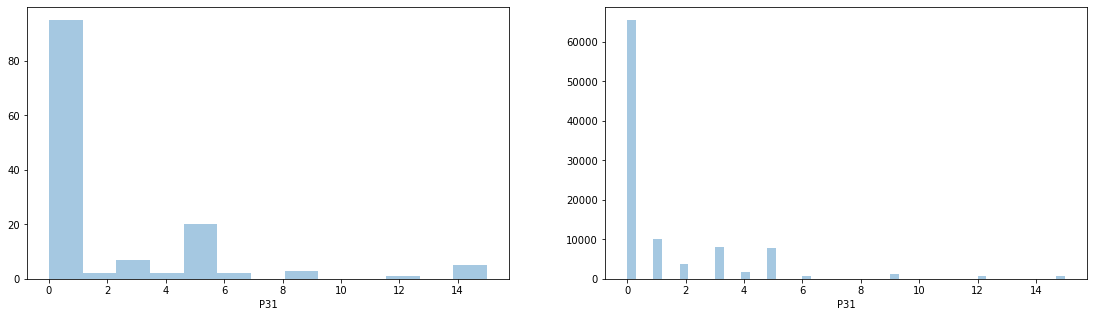

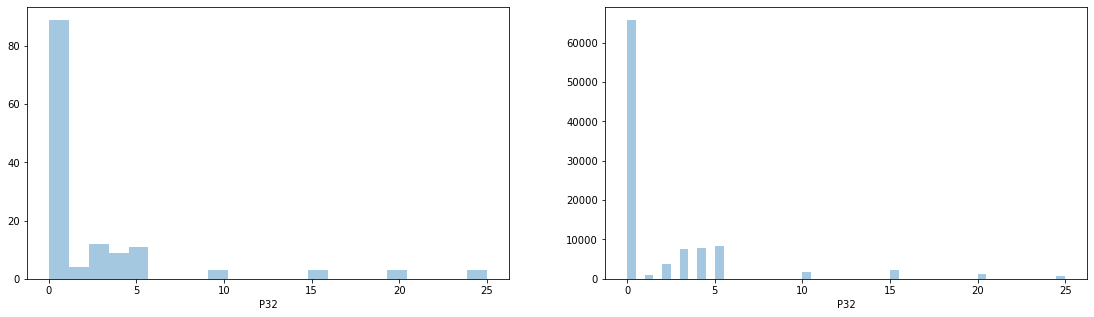

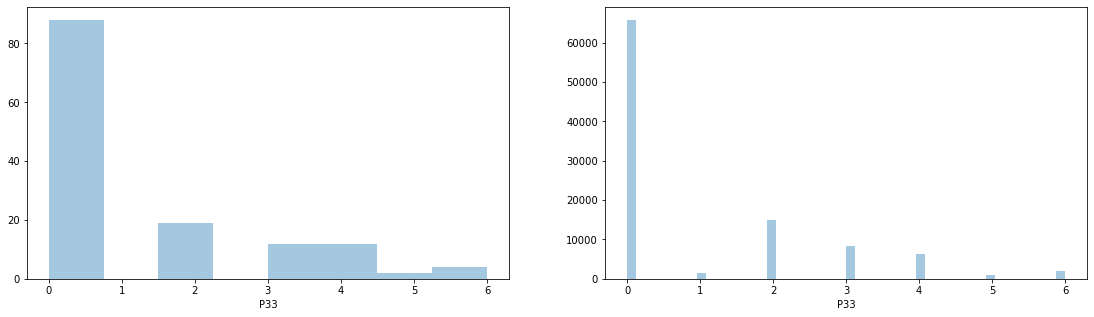

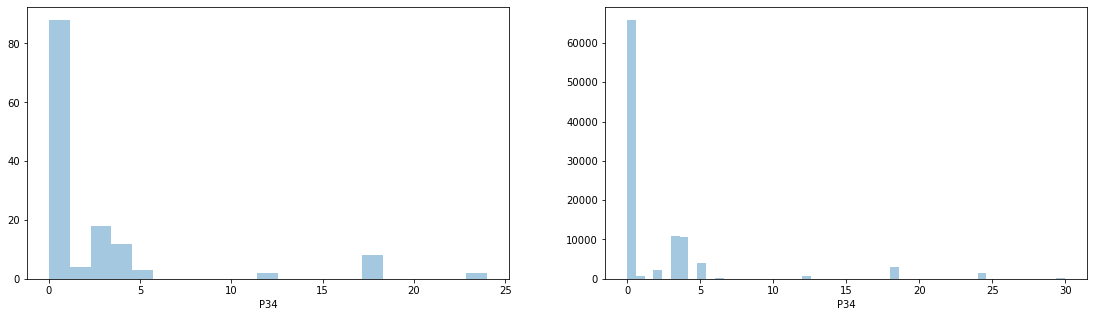

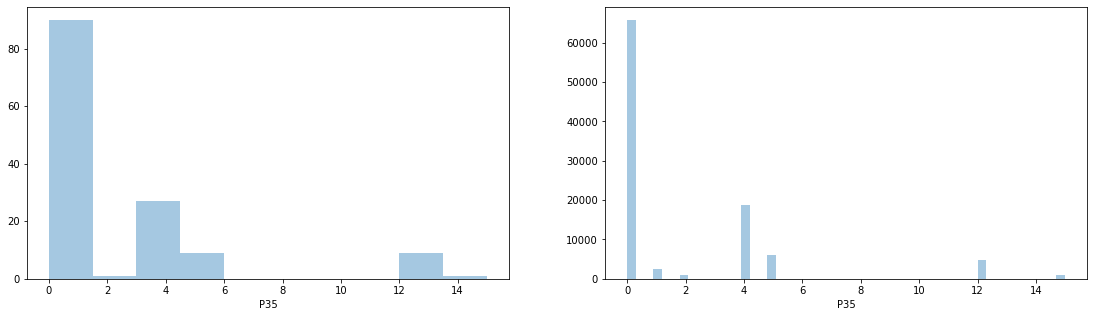

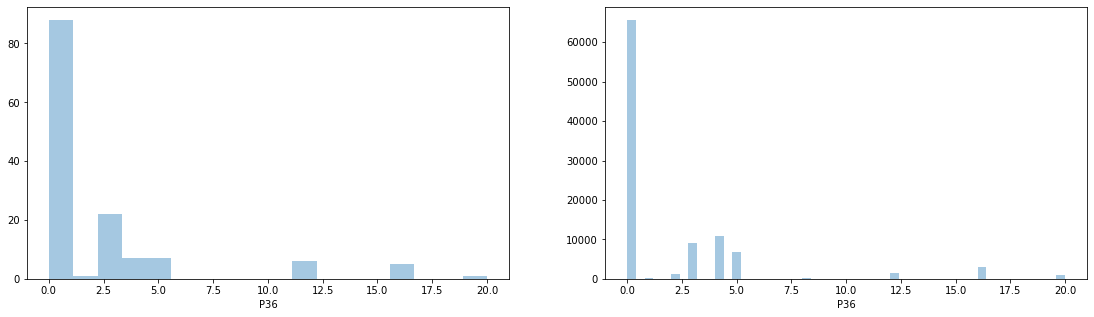

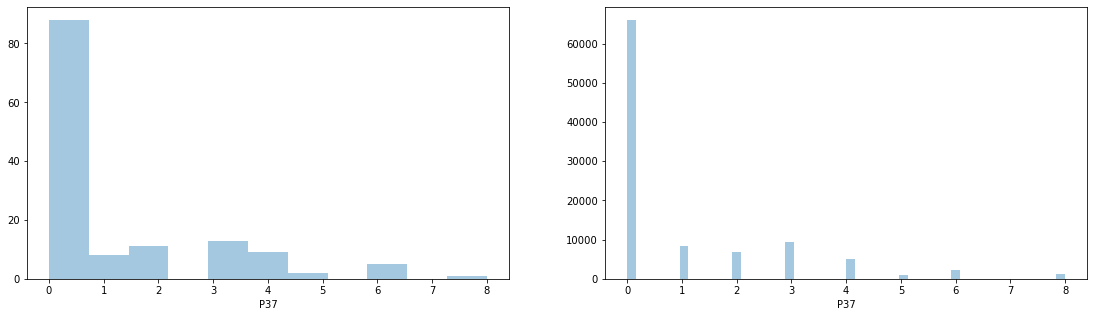

In [12]:
plt.rc('figure', max_open_warning = 0)
for i in range(1,38):
    fig, ax = plt.subplots(1,2, figsize=(19, 5))
    g1 = sns.distplot(df['P{}'.format(i)], ax=ax[0], kde=False);
    g2 = sns.distplot(test_df['P{}'.format(i)], ax=ax[1], kde=False);
    fig.show()

**Categorical**

In [13]:
df.dtypes

City Group     object
Type           object
P1              int64
P2            float64
P3            float64
P4            float64
P5              int64
P6              int64
P7              int64
P8              int64
P9              int64
P10             int64
P11             int64
P12             int64
P13           float64
P14             int64
P15             int64
P16             int64
P17             int64
P18             int64
P19             int64
P20             int64
P21             int64
P22             int64
P23             int64
P24             int64
P25             int64
P26           float64
P27           float64
P28           float64
P29           float64
P30             int64
P31             int64
P32             int64
P33             int64
P34             int64
P35             int64
P36             int64
P37             int64
revenue       float64
Days Open     float64
dtype: object

In [14]:
# one hot encoding
columnsToEncode = df.select_dtypes(include=[object]).columns
df = pd.get_dummies(df, columns=columnsToEncode, drop_first=False)
test_df = pd.get_dummies(test_df, columns=columnsToEncode, drop_first=False)

**Revenue Distribution**

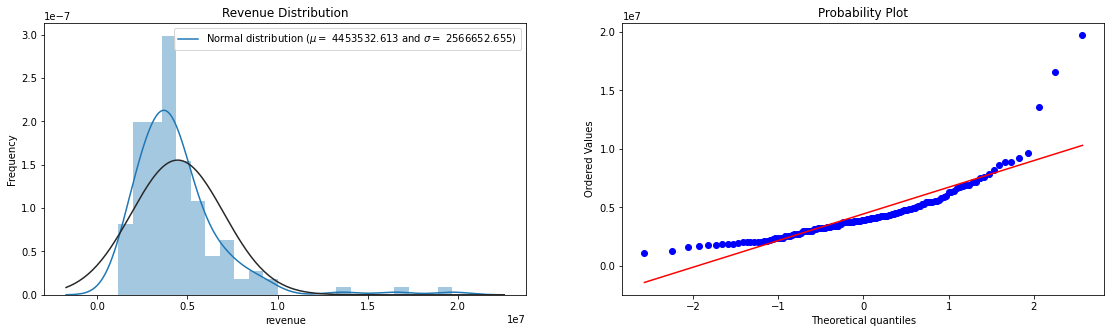

In [15]:
(mu, sigma) = norm.fit(df['revenue'])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5))
ax1 = sns.distplot(df['revenue'] , fit=norm, ax=ax1)
ax1.legend([f'Normal distribution ($\mu=$ {mu:.3f} and $\sigma=$ {sigma:.3f})'], loc='best')
ax1.set_ylabel('Frequency')
ax1.set_title('Revenue Distribution')
ax2 = stats.probplot(df['revenue'], plot=plt)
f.show();

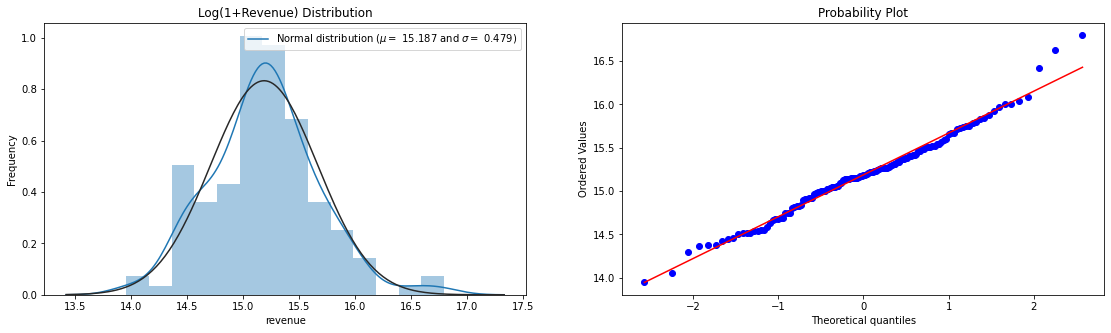

In [16]:
# Revenue is right skewed, taking the log will make it more normally distributed for the linear models
# Use expm1 on predictions to transform back to dollar amount
(mu, sigma) = norm.fit(np.log1p(df['revenue']))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(19, 5))
ax1 = sns.distplot(np.log1p(df['revenue']) , fit=norm, ax=ax1)
ax1.legend([f'Normal distribution ($\mu=$ {mu:.3f} and $\sigma=$ {sigma:.3f})'], loc='best')
ax1.set_ylabel('Frequency')
ax1.set_title('Log(1+Revenue) Distribution')
ax2 = stats.probplot(np.log(df['revenue']), plot=plt)
f.show();

### Models

In [17]:
df['revenue'] = np.log1p(df['revenue'])
X, y = df.drop('revenue', axis=1), df['revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=118)

**Ridge and Lasso regression**

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [19]:
params_ridge = {
    'alpha' : [.01, .1, .5, .7, .9, .95, .99, 1, 5, 10, 20],
    'fit_intercept' : [True, False],
    'normalize' : [True,False],
    'solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

ridge_model = Ridge()
ridge_regressor = GridSearchCV(ridge_model, params_ridge, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
ridge_regressor.fit(X_train, y_train)
print(f'Optimal alpha: {ridge_regressor.best_params_["alpha"]:.2f}')
print(f'Optimal fit_intercept: {ridge_regressor.best_params_["fit_intercept"]}')
print(f'Optimal normalize: {ridge_regressor.best_params_["normalize"]}')
print(f'Optimal solver: {ridge_regressor.best_params_["solver"]}')
print(f'Best score: {ridge_regressor.best_score_}')

Optimal alpha: 1.00
Optimal fit_intercept: True
Optimal normalize: True
Optimal solver: saga
Best score: -0.44222973796313625


In [20]:
ridge_model = Ridge(alpha=ridge_regressor.best_params_["alpha"], fit_intercept=ridge_regressor.best_params_["fit_intercept"], 
                    normalize=ridge_regressor.best_params_["normalize"], solver=ridge_regressor.best_params_["solver"])
ridge_model.fit(X_train, y_train)
y_train_pred = ridge_model.predict(X_train)
y_pred = ridge_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -9.53859524931601
Test r2 score:  0.10389685863493647
Train RMSE: 0.4105
Test RMSE: 0.5232


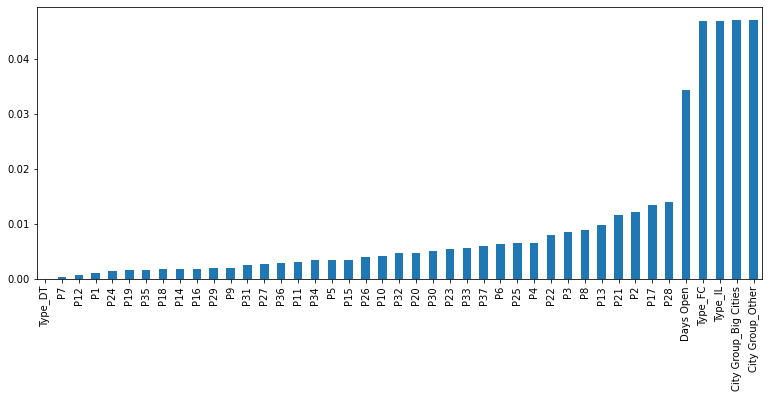

In [21]:
# Ridge Model Feature Importance
ridge_feature_coef = pd.Series(index = X_train.columns, data = np.abs(ridge_model.coef_))
ridge_feature_coef.sort_values().plot(kind = 'bar', figsize = (13,5));

In [22]:
params_lasso = {
    'alpha' : [.01, .1, .5, .7, .9, .95, .99, 1, 5, 10, 20],
    'fit_intercept' : [True, False],
    'normalize' : [True,False],
}

lasso_model = Lasso()
lasso_regressor = GridSearchCV(lasso_model, params_lasso, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
lasso_regressor.fit(X_train, y_train)
print(f'Optimal alpha: {lasso_regressor.best_params_["alpha"]:.2f}')
print(f'Optimal fit_intercept: {lasso_regressor.best_params_["fit_intercept"]}')
print(f'Optimal normalize: {lasso_regressor.best_params_["normalize"]}')
print(f'Best score: {lasso_regressor.best_score_}')

Optimal alpha: 0.10
Optimal fit_intercept: True
Optimal normalize: False
Best score: -0.4452847908679775


In [23]:
lasso_model = Lasso(alpha=lasso_regressor.best_params_["alpha"], fit_intercept=lasso_regressor.best_params_["fit_intercept"], 
                    normalize=lasso_regressor.best_params_["normalize"])
lasso_model.fit(X_train, y_train)
y_train_pred = lasso_model.predict(X_train)
y_pred = lasso_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -19.357185893022436
Test r2 score:  0.06759562041733402
Train RMSE: 0.4288
Test RMSE: 0.5337


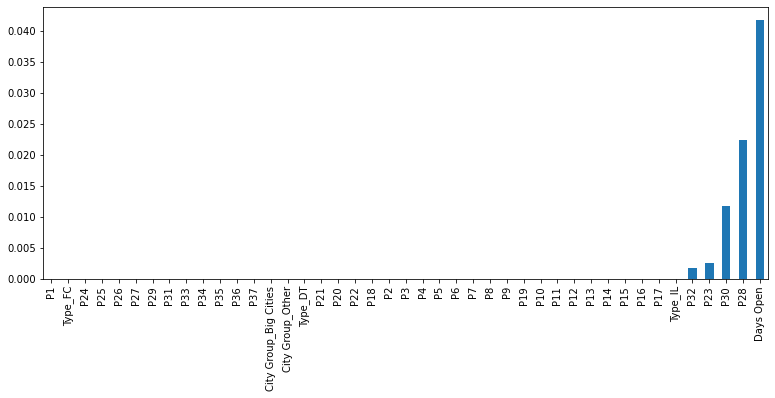

In [24]:
# Lasso Model Feature Importance
lasso_feature_coef = pd.Series(index = X_train.columns, data = np.abs(lasso_model.coef_))
lasso_feature_coef.sort_values().plot(kind = 'bar', figsize = (13,5));

**ElasticNet (combination of Ridge & Lasso)**

In [25]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

# Use ElasticNetCV to tune alpha automatically instead of redundantly using ElasticNet and GridSearchCV
el_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=5e-2, cv=10, n_jobs=-1)         
el_model.fit(X_train, y_train)
print(f'Optimal alpha: {el_model.alpha_:.6f}')
print(f'Optimal l1_ratio: {el_model.l1_ratio_:.3f}')
print(f'Number of iterations {el_model.n_iter_}')

Optimal alpha: 0.654552
Optimal l1_ratio: 0.100
Number of iterations 22


In [26]:
y_train_pred = el_model.predict(X_train)
y_pred = el_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -13.303778284294907
Test r2 score:  0.07202854111415335
Train RMSE: 0.4208
Test RMSE: 0.5324


8 features with reduction of 81.40%


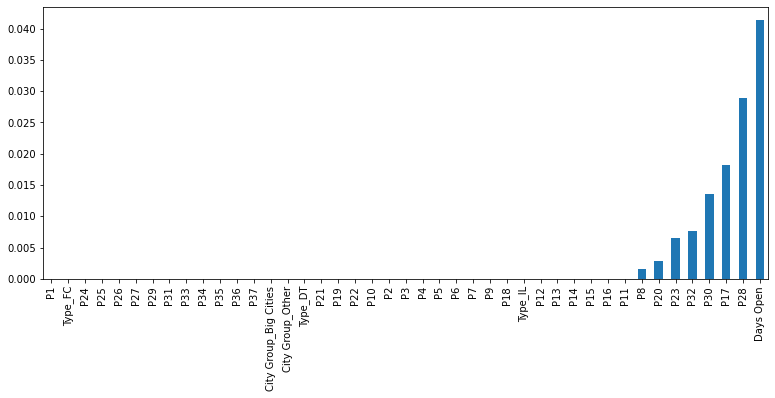

In [27]:
# ElasticNet Model Feature Importance
el_feature_coef = pd.Series(index = X_train.columns, data = np.abs(el_model.coef_))
n_features = (el_feature_coef>0).sum()
print(f'{n_features} features with reduction of {(1-n_features/len(el_feature_coef))*100:2.2f}%')
el_feature_coef.sort_values().plot(kind = 'bar', figsize = (13,5));

**KNN**

In [28]:
from sklearn.neighbors import KNeighborsRegressor

params_knn = {
    'n_neighbors' : [3, 5, 7, 9, 11],
}

knn_model = KNeighborsRegressor()
knn_regressor = GridSearchCV(knn_model, params_knn, scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1)
knn_regressor.fit(X_train, y_train)
print(f'Optimal neighbors: {knn_regressor.best_params_["n_neighbors"]}')
print(f'Best score: {knn_regressor.best_score_}')

Optimal neighbors: 9
Best score: -0.41107510768078015


In [29]:
knn_model = KNeighborsRegressor(n_neighbors=knn_regressor.best_params_["n_neighbors"])
knn_model.fit(X_train, y_train)
y_train_pred = knn_model.predict(X_train)
y_pred = knn_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -3.444336745211438
Test r2 score:  0.06561873270354524
Train RMSE: 0.3930
Test RMSE: 0.5342


**lightgbm**

In [33]:
import lightgbm as lgbm

params_lgbm = {
    'learning_rate': [.01, .1, .5, .7, .9, .95, .99, 1],
    'boosting': ['gbdt'],
    'metric': ['l1'],
    'feature_fraction': [.3, .4, .5, 1],
    'num_leaves': [20],
    'min_data': [10],
    'max_depth': [10],
    'n_estimators': [10, 30, 50, 100]
}

lgb = lgbm.LGBMRegressor()
lgb_regressor = GridSearchCV(lgb, params_lgbm, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
lgb_regressor.fit(X_train, y_train)
print(f'Optimal lr: {lgb_regressor.best_params_["learning_rate"]}')
print(f'Optimal feature_fraction: {lgb_regressor.best_params_["feature_fraction"]}')
print(f'Optimal n_estimators: {lgb_regressor.best_params_["n_estimators"]}')
print(f'Best score: {lgb_regressor.best_score_}')

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_data=10. Current value: min_data_in_leaf=10
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
Optimal lr: 0.1
Optimal feature_fraction: 0.4
Optimal n_estimators: 50
Best score: -0.39542147006788125


In [34]:
lgb_model = lgbm.LGBMRegressor(learning_rate=lgb_regressor.best_params_["learning_rate"], boosting='gbdt', 
                               metric='l1', feature_fraction=lgb_regressor.best_params_["feature_fraction"], 
                               num_leaves=20, min_data=10, max_depth=10, 
                               n_estimators=lgb_regressor.best_params_["n_estimators"], n_jobs=-1)
lgb_model.fit(X_train, y_train)
y_train_pred = lgb_model.predict(X_train)
y_pred = lgb_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  0.623730691452548
Test r2 score:  0.25162346962035687
Train RMSE: 0.1990
Test RMSE: 0.4781


39 features with reduction of 9.30%


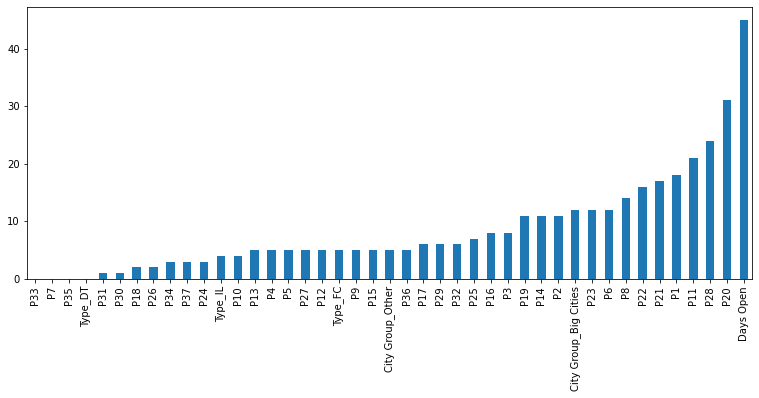

In [35]:
# LightGBM Feature Importance
lgb_feature_importance = pd.Series(index = X_train.columns, data = np.abs(lgb_model.feature_importances_))
n_features = (lgb_feature_importance>0).sum()
print(f'{n_features} features with reduction of {(1-n_features/len(lgb_feature_importance))*100:2.2f}%')
lgb_feature_importance.sort_values().plot(kind = 'bar', figsize = (13,5));

**XGBoosting**

In [36]:
params_xgb = {
    'learning_rate': [.1, .5, .7, .9, .95, .99, 1],
    'colsample_bytree': [.3, .4, .5, .6],
    'max_depth': [4],
    'alpha': [3],
    'subsample': [.5],
    'n_estimators': [30, 70, 100, 200]
}

xgb_model = XGBRegressor()
xgb_regressor = GridSearchCV(xgb_model, params_xgb, scoring='neg_root_mean_squared_error', cv = 10, n_jobs = -1)
xgb_regressor.fit(X_train, y_train)
print(f'Optimal lr: {xgb_regressor.best_params_["learning_rate"]}')
print(f'Optimal colsample_bytree: {xgb_regressor.best_params_["colsample_bytree"]}')
print(f'Optimal n_estimators: {xgb_regressor.best_params_["n_estimators"]}')
print(f'Best score: {xgb_regressor.best_score_}')

Optimal lr: 0.9
Optimal colsample_bytree: 0.3
Optimal n_estimators: 30
Best score: -0.40213172143940856


In [37]:
xgb_model = XGBRegressor(learning_rate=xgb_regressor.best_params_["learning_rate"], 
                         colsample_bytree=xgb_regressor.best_params_["colsample_bytree"], 
                         max_depth=4, alpha=3, subsample=.5, 
                         n_estimators=xgb_regressor.best_params_["n_estimators"], n_jobs=-1)
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -0.5328395884534278
Test r2 score:  0.2584841383890041
Train RMSE: 0.3158
Test RMSE: 0.4759


In [38]:
# XGB with early stopping
xgb_model.fit(X_train, y_train, early_stopping_rounds=4,
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred = xgb_model.predict(X_train)
y_pred = xgb_model.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  -6.802332105037986
Test r2 score:  0.16692312781172547
Train RMSE: 0.4102
Test RMSE: 0.5044


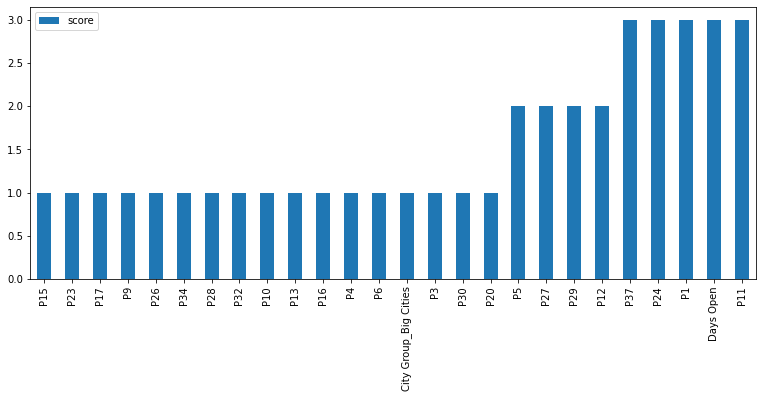

In [39]:
# XGB Feature Importance, relevant features can be selected based on its score
feature_important = xgb_model.get_booster().get_fscore()
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=['score']).sort_values(by = 'score', ascending=True)
data.plot(kind='bar', figsize = (13,5))
plt.show()

**Regressor Ensembling**

In [40]:
rf_model_en = RandomForestRegressor(max_depth=200, max_features=0.4, min_samples_leaf=3, 
                                 min_samples_split=6, n_estimators=30, n_jobs=-1, oob_score=True)
rf_model_en.fit(X_train, y_train)
y_train_pred = rf_model_en.predict(X_train)
y_pred = rf_model_en.predict(X_test)
print('Train r2 score: ', r2_score(y_train_pred, y_train))
print('Test r2 score: ', r2_score(y_test, y_pred))
train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train r2 score:  0.16286989666956542
Test r2 score:  0.273315225715262
Train RMSE: 0.2477
Test RMSE: 0.4711


ridge -0.350 0.083
lasso -0.351 0.088
rf_en -0.334 0.077
stacking -0.347 0.079


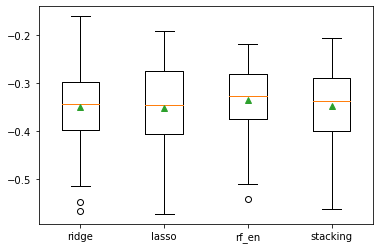

In [41]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot

# get a stacking ensemble of models
def get_stacking():
    # define the base models
    base_models = list()
    base_models.append(('ridge', ridge_model))
    base_models.append(('lasso', lasso_model))
    base_models.append(('rf', rf_model_en))
    # define meta learner model
    learner = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=base_models, final_estimator=learner, cv=10)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['ridge'] = ridge_model
    models['lasso'] = lasso_model
    models['rf_en'] = rf_model_en
    models['stacking'] = get_stacking()
    return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=19)
    scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print(f'{name} {mean(scores):.3f} {std(scores):.3f}')
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [42]:
# define the base models
base_models = list()
base_models.append(('ridge', ridge_model))
base_models.append(('lasso', lasso_model))
base_models.append(('rf', rf_model_en))
# define meta learner model
learner = LinearRegression()
# define the stacking ensemble
stack1 = StackingRegressor(estimators=base_models, final_estimator=learner, cv=10)
# fit the model on all available data
stack1.fit(X, y)

StackingRegressor(cv=10,
                  estimators=[('ridge',
                               Ridge(alpha=1, normalize=True, solver='saga')),
                              ('lasso', Lasso(alpha=0.1)),
                              ('rf',
                               RandomForestRegressor(max_depth=200,
                                                     max_features=0.4,
                                                     min_samples_leaf=3,
                                                     min_samples_split=6,
                                                     n_estimators=30, n_jobs=-1,
                                                     oob_score=True))],
                  final_estimator=LinearRegression())